Dennis Wang

This notebook is currently a mess.

Dataset from https://www.kaggle.com/datasets/samuelotiattakorah/healthcare-no-show-appointment-data

Data is not iid and large (100k+ rows)

Background on Data:
Information on 100k+ medical appointments from various neighborhoods in Brazil, with the goal of predicting whether or not a patient would show up to their appointment. Further information on the actual data collection or source couldn't be found :/

Presentation should be 6 minutes, + 2-3 minutes ofr questions

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.5"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.5"):
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.26.4", 'matplotlib': "3.9.2",'sklearn': "1.5.1", 
                'pandas': "2.2.2",'xgboost': "2.1.1", 'shap': "0.45.1", 
                'plotly': "5.23.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.5

[ OK ] numpy version 1.26.4 is installed.
[ OK ] matplotlib version 3.9.2 is installed.
[ OK ] sklearn version 1.5.1 is installed.
[ OK ] pandas version 2.2.2 is installed.
[ OK ] xgboost version 2.1.1 is installed.
[ OK ] shap version 0.45.1 is installed.
[ OK ] plotly version 5.23.0 is installed.


## EDA

Show us what you think were the most interesting, unexpected, or important insights that you gained during EDA. Present at least three different informative visualization types. Do not create only three figures. Create as many figures you can to better understand your dataset and calculate summary statistics as well. Then select three figures that you want to show during the presentation. Explain why you chose the figures! Why are they interesting, unexpected, important?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/healthcare_noshows_appointments.csv', dtype={'PatientId': str, 'AppointmentID': str})
#df['PatientId'] = df['PatientId'].astype(int).astype(str)
display(df.head())
display(df.shape)
display(df.info())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


(106987, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientId       106987 non-null  object
 1   AppointmentID   106987 non-null  object
 2   Gender          106987 non-null  object
 3   ScheduledDay    106987 non-null  object
 4   AppointmentDay  106987 non-null  object
 5   Age             106987 non-null  int64 
 6   Neighbourhood   106987 non-null  object
 7   Scholarship     106987 non-null  bool  
 8   Hipertension    106987 non-null  bool  
 9   Diabetes        106987 non-null  bool  
 10  Alcoholism      106987 non-null  bool  
 11  Handcap         106987 non-null  bool  
 12  SMS_received    106987 non-null  bool  
 13  Showed_up       106987 non-null  bool  
 14  Date.diff       106987 non-null  int64 
dtypes: bool(7), int64(2), object(6)
memory usage: 7.2+ MB


None

The inconsistency of the columns names are really annoying me so I'm renaming them.

In [4]:
df = df.rename(columns={"PatientId": "PatientID", "Showed_up": "ShowedUp", "Date.diff": "DateDiff","Hipertension":"Hypertension", "Handcap":"Handicap"})
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientID       106987 non-null  object
 1   AppointmentID   106987 non-null  object
 2   Gender          106987 non-null  object
 3   ScheduledDay    106987 non-null  object
 4   AppointmentDay  106987 non-null  object
 5   Age             106987 non-null  int64 
 6   Neighbourhood   106987 non-null  object
 7   Scholarship     106987 non-null  bool  
 8   Hypertension    106987 non-null  bool  
 9   Diabetes        106987 non-null  bool  
 10  Alcoholism      106987 non-null  bool  
 11  Handicap        106987 non-null  bool  
 12  SMS_received    106987 non-null  bool  
 13  ShowedUp        106987 non-null  bool  
 14  DateDiff        106987 non-null  int64 
dtypes: bool(7), int64(2), object(6)
memory usage: 7.2+ MB


None

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,ShowedUp,DateDiff
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


It seems a lot of our columns are binary. We know each row represents each appointment, but to check if there's overlap between patients:

In [5]:
display(len(df['PatientID'].unique()))
display(len(df['AppointmentID'].unique()))

60270

106987

Since some patients appear more than once in the dataset, we will have to stratify by patient when splitting later on.

Immediately drop column 'AppointmentID' because we don't need the unique appointment identifier.

I'm considering dropping columns 'ScheduledDay' and 'AppointmentDay' because DateDiff relies on those two columns and sees like an easier attribute to work with.
But maybe we can do something with the day of the week of either the ScheduledDay or AppointmentDay?

In [6]:
df = df.drop(['AppointmentID'], axis=1)


In [7]:
df = df[['PatientID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'DateDiff', 'Age',
       'Neighbourhood', 'Scholarship', 'Hypertension', 'Diabetes',
       'Alcoholism', 'Handicap', 'SMS_received','ShowedUp']]
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]

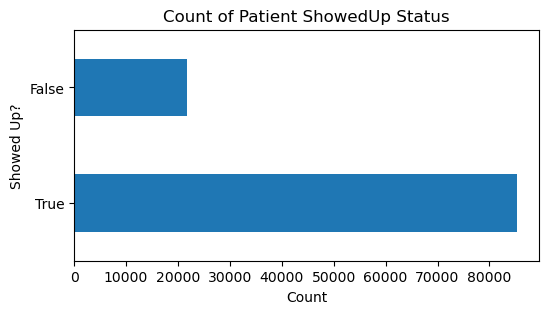

In [8]:
# visualizing our target variable
plt.figure(figsize=(6,3))
df['ShowedUp'].value_counts().plot.barh()
plt.xlabel('Count')
plt.ylabel('Showed Up?')
plt.title('Count of Patient ShowedUp Status')
plt.show()
# is it okay if i don't have a caption if I talk about the plot in the markdown?

Looks like our categorical target variable, ShowedUp, is highly imbalanced. Most people thankfully show up to their appointment.

How about checking some of our other categorical variables - Gender and Neighbourhood? Also check the distribution of age.

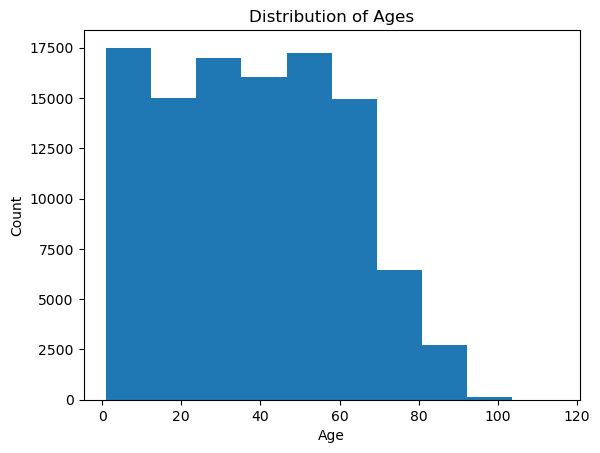

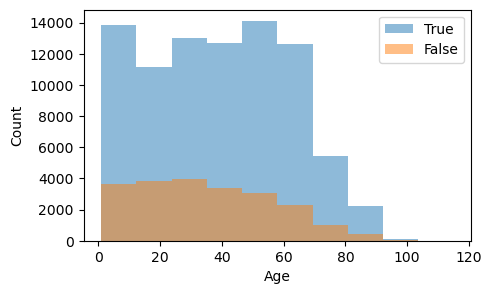

In [9]:
fig, ax = plt.subplots()
ax.hist(df['Age'])
ax.set_title('Distribution of Ages')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()



categories = df['ShowedUp'].unique()
bin_range = (df['Age'].min(), df['Age'].max())

plt.figure(figsize=(5,3))

for c in categories:
    plt.hist(df[df['ShowedUp']==c]['Age'] ,alpha=0.5, label=c, range=bin_range, bins=10)
plt.legend()
plt.ylabel('Count')
plt.xlabel('Age')
plt.show()

Relatively uniform with a bit of right skew.

In [10]:
display(df['DateDiff'][df['ShowedUp'] == 1].describe())
(df['DateDiff'][df['ShowedUp'] == 0].describe())


count    85307.000000
mean         8.737794
std         14.558336
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max        179.000000
Name: DateDiff, dtype: float64

count    21680.000000
mean        15.789299
std         16.615843
min         -6.000000
25%          4.000000
50%         10.500000
75%         23.000000
max        179.000000
Name: DateDiff, dtype: float64

DateDiff is very unbalanced

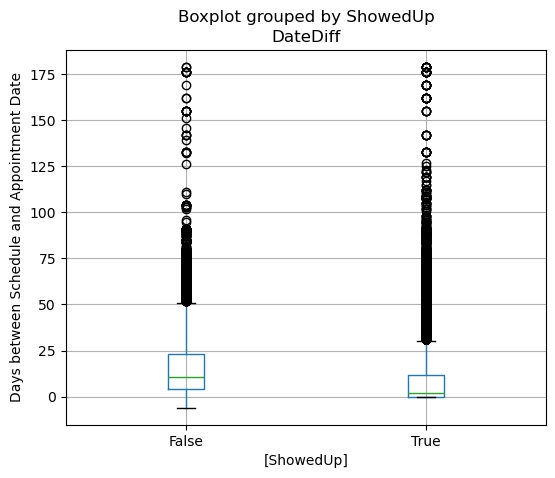

In [11]:
df[['DateDiff','ShowedUp']].boxplot(by='ShowedUp',figsize=(6,5))
plt.ylabel('Days between Schedule and Appointment Date')
plt.show()

Lots of outliers in both categories... Maybe we can visualize this differently.

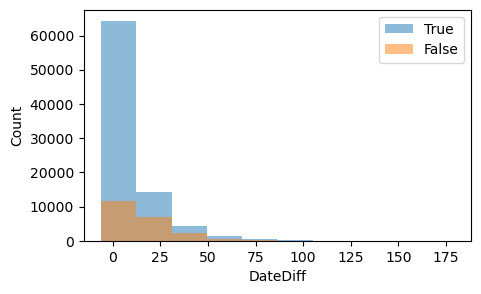

In [12]:
categories = df['ShowedUp'].unique()
bin_range = (df['DateDiff'].min(), df['DateDiff'].max())

plt.figure(figsize=(5,3))

for c in categories:
    plt.hist(df[df['ShowedUp']==c]['DateDiff'] ,alpha=0.5, label=c, range=bin_range, bins=10)
plt.legend()
plt.ylabel('Count')
plt.xlabel('DateDiff')
plt.show()

Of the people who schedule more than 1 month in advance, are they more likely to show up? 

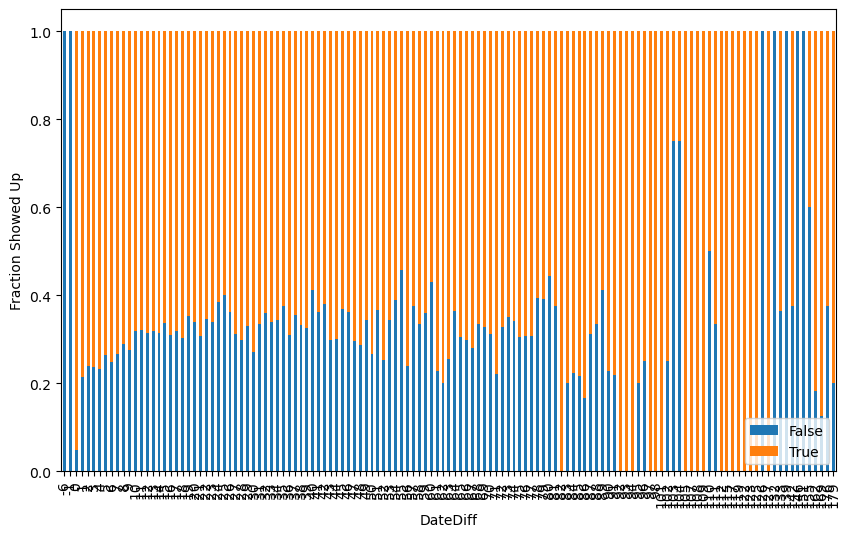

In [13]:
count_matrix = df.groupby(['DateDiff', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True,figsize=(10,6))
plt.ylabel('Fraction Showed Up')
plt.legend(loc=4)
plt.show()

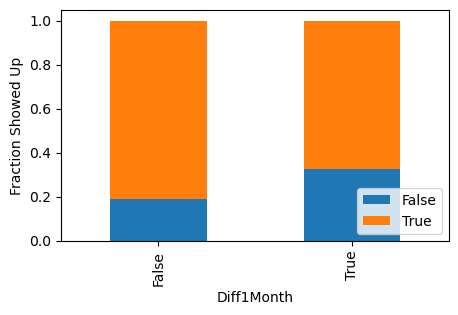

In [14]:
df['Diff1Month'] = df['DateDiff'] >= 30

count_matrix = df.groupby(['Diff1Month', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('Fraction Showed Up')
plt.legend(loc=4)
plt.show()

## OR rather graph Didn't Show Up fraction vs. DateDiff?

In [15]:
df2 = df[df['ShowedUp'] == False].groupby("DateDiff").count().reset_index()[['DateDiff', 'ShowedUp']].rename(columns = {"DateDiff":"DateDiff", "ShowedUp":"No Shows"}).set_index(['DateDiff'])
df3 = df.groupby("DateDiff").count().reset_index()[['DateDiff', 'ShowedUp']].rename(columns = {"DateDiff":"DateDiff", "ShowedUp":"TotalCount"}).set_index(['DateDiff'])

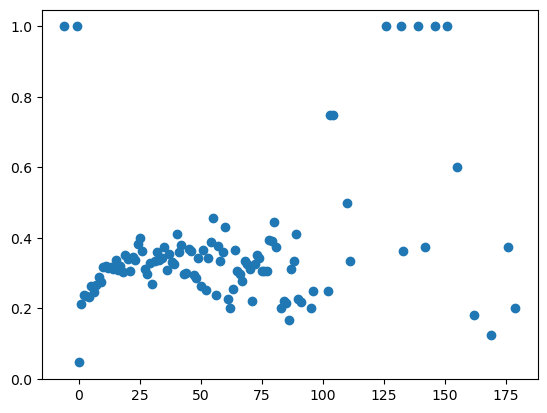

In [16]:
#pd.concat([df2, df3], axis=1)
df23 = df2.merge(df3, on='DateDiff', how='outer')
df23['NoShow_Prop'] = df23['No Shows'] / df23['TotalCount']
df23 = df23.reset_index()

plt.scatter(df23['DateDiff'], df23['NoShow_Prop'])


C:\Users\DWang\AppData\Local\Temp\ipykernel_23784\3999155371.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df23_binned = df23[['DateDiff_Bin','No Shows', 'TotalCount']].groupby(['DateDiff_Bin']).sum().reset_index()


<Axes: >

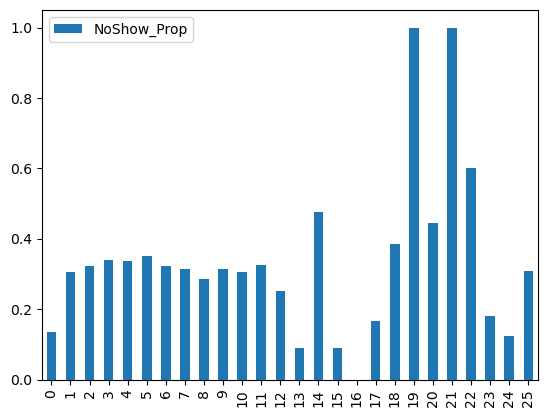

In [17]:
"""
fig, ax = plt.subplots()
plt.bar(df23['DateDiff'], df23['NoShow_Prop'])

ax.set_xlabel("DateDiff")
ax.set_ylabel("Showed Up")
plt.show()
"""
df23 = df2.merge(df3, on='DateDiff', how='outer')
df23 = df23.reset_index()
bins = np.arange(0,184, 7)
df23['DateDiff_Bin'] = pd.cut(df23['DateDiff'], bins=bins, include_lowest=True)
df23_binned = df23[['DateDiff_Bin','No Shows', 'TotalCount']].groupby(['DateDiff_Bin']).sum().reset_index()

df23_binned['NoShow_Prop'] = df23_binned['No Shows'] / df23_binned['TotalCount']
df23_binned
df23_binned[['DateDiff_Bin', 'NoShow_Prop']].plot(kind='bar')

Kind of inconclusive, but variability definitely increases as DateDiff increases.

In [18]:
df.columns

Index(['PatientID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'DateDiff',
       'Age', 'Neighbourhood', 'Scholarship', 'Hypertension', 'Diabetes',
       'Alcoholism', 'Handicap', 'SMS_received', 'ShowedUp', 'Diff1Month'],
      dtype='object')

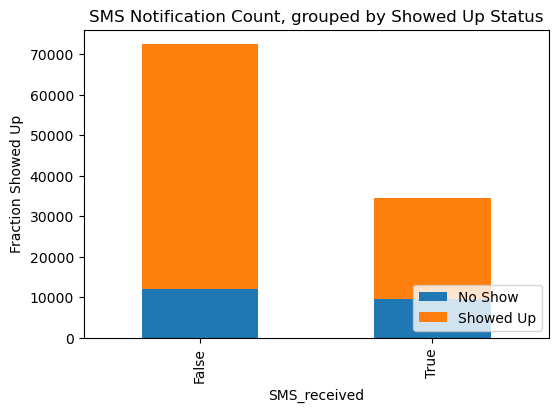

In [19]:
fig, ax = plt.subplots(figsize=(6,4))
p = df.groupby(['SMS_received', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.ylabel('Fraction Showed Up')
plt.legend(["No Show", "Showed Up"],loc=4)
plt.title("SMS Notification Count, grouped by Showed Up Status")
plt.show()


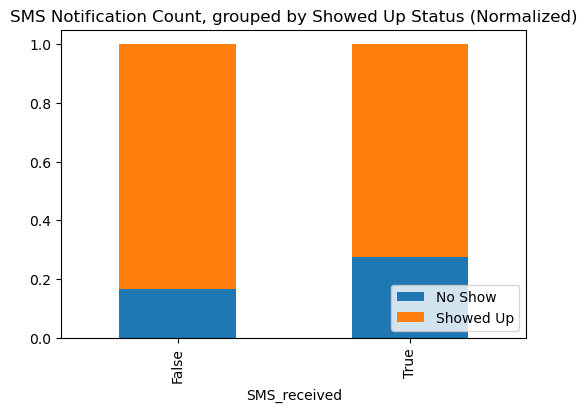

In [20]:

count_matrix = df.groupby(['SMS_received', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(6,4))
plt.title("SMS Notification Count, grouped by Showed Up Status (Normalized)")
plt.legend(["No Show", "Showed Up"],loc=4)
plt.show()

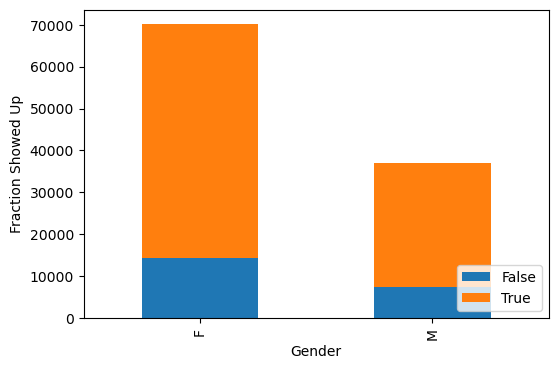

In [21]:
fig, ax = plt.subplots(figsize=(6,4))
p = df.groupby(['Gender', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.ylabel('Fraction Showed Up')
plt.legend(loc=4)
plt.show()


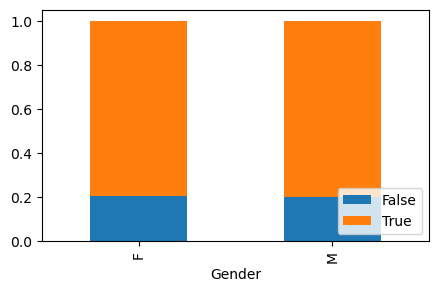

In [22]:
count_matrix = df.groupby(['Gender', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.legend(loc=4)

Twice as many Females as Males in our dataset.

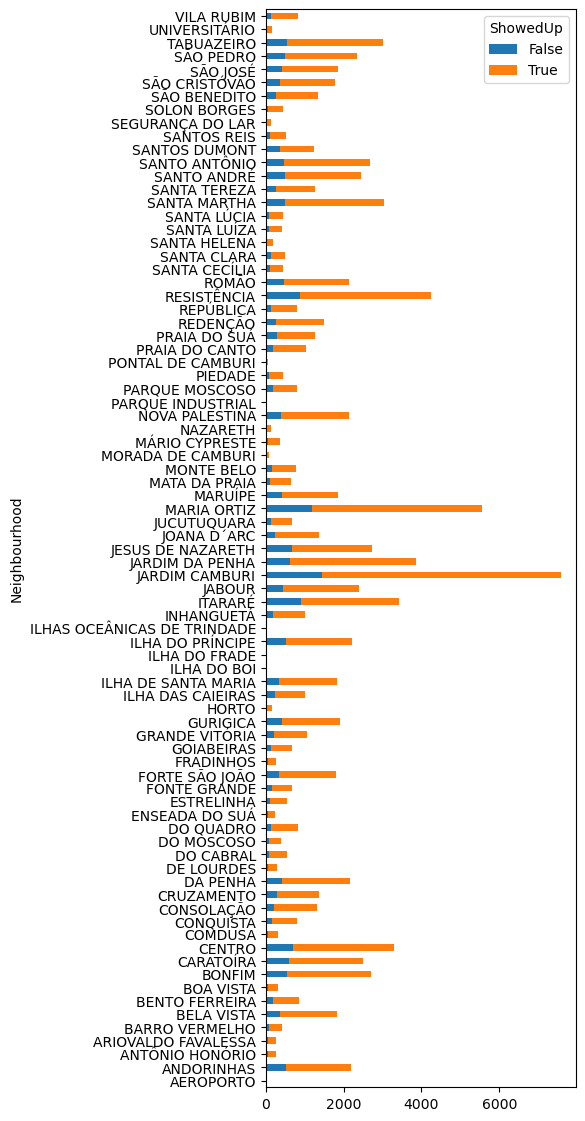

In [23]:
fig, ax = plt.subplots(figsize = (4,14))
p = df.groupby(['Neighbourhood', 'ShowedUp']).size().unstack().plot.barh(stacked=True, ax=ax)
plt.show()

Looks like there's definitely more representation from some neighbourhoods compared to others.

In [24]:
df.loc[:, df.isnull().any() ]

""
0
1
2
3
4
...
106982
106983
106984
106985


no nulls

# Testing relationships between our features and target variable

<Figure size 2000x1200 with 0 Axes>

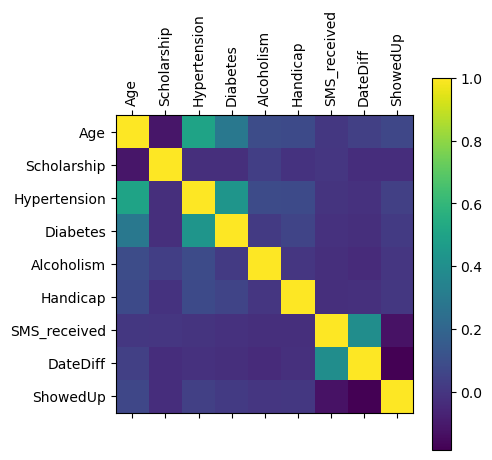

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,DateDiff,ShowedUp
Age,1.000000,-0.112699,0.502091,0.290631,0.090391,0.079726,0.005251,0.038880,0.067025
Scholarship,-0.112699,1.000000,-0.024530,-0.027622,0.033527,-0.010465,-0.000010,-0.030439,-0.029370
Hypertension,0.502091,-0.024530,1.000000,0.430827,0.085459,0.082909,-0.008805,-0.016996,0.037280
Diabetes,0.290631,-0.027622,0.430827,1.000000,0.016874,0.057945,-0.016136,-0.027339,0.015928
Alcoholism,0.090391,0.033527,0.085459,0.016874,1.000000,0.002864,-0.027403,-0.038949,0.000517
Handicap,0.079726,-0.010465,0.082909,0.057945,0.002864,1.000000,-0.026256,-0.021101,0.007620
SMS_received,0.005251,-0.000010,-0.008805,-0.016136,-0.027403,-0.026256,1.000000,0.396482,-0.127253
DateDiff,0.038880,-0.030439,-0.016996,-0.027339,-0.038949,-0.021101,0.396482,1.000000,-0.185704
ShowedUp,0.067025,-0.029370,0.037280,0.015928,0.000517,0.007620,-0.127253,-0.185704,1.000000


In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
df_num = df[['Age','Scholarship','Hypertension','Diabetes','Alcoholism','Handicap','SMS_received', 'DateDiff', 'ShowedUp']]

pearson_corr = df_num.corr(method='pearson')

plt.figure(figsize = (20,12))
plt.matshow(pearson_corr)
plt.xticks(range(df_num.shape[1]), df_num.columns, rotation = 90)
plt.yticks(range(df_num.shape[1]), df_num.columns)
cb = plt.colorbar()
plt.show()

## or use .background_gradient()? I really prefer having the correlation # in the cell 
# but not sure how to do that with .matshow() without it getting too complicated
pearson_corr.style.background_gradient(cmap='coolwarm')

# or i could use seaborn...


Not that much correlation between our features.

How about linear correlations between our features and the target variable?

In [26]:
Y

,ShowedUp
0,True
1,True
2,True
3,True
4,True
...,...
106982,True
106983,True
106984,True
106985,True


Text(0, 0.5, 'F-statistic')

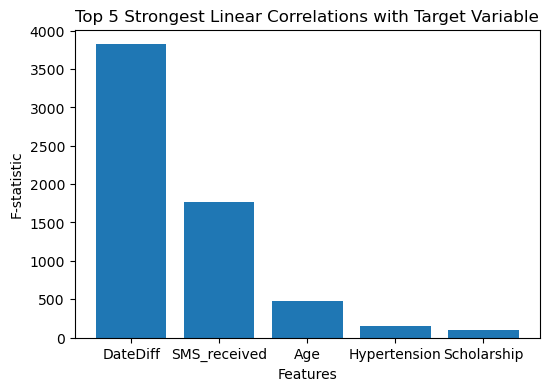

In [27]:
from sklearn.feature_selection import f_regression

X_nums = df_num.drop(['ShowedUp'], axis=1)
Y_nums = np.ravel(df_num.iloc[:,-1:])

f_statistic, p_values = f_regression(X_nums, Y_nums)

cols = X_nums.columns
f_df = pd.DataFrame(data = f_statistic, index = cols).sort_values(by=0, ascending = False).head(5)

plt.figure(figsize=(6,4))
plt.bar(x=f_df.index, height = f_df[0])
plt.title('Top 5 Strongest Linear Correlations with Target Variable')
plt.xlabel('Features')
plt.ylabel('F-statistic')


How about non-linear correlations? i.e. mutual information

Text(0, 0.5, 'Estimated Mutual Information')

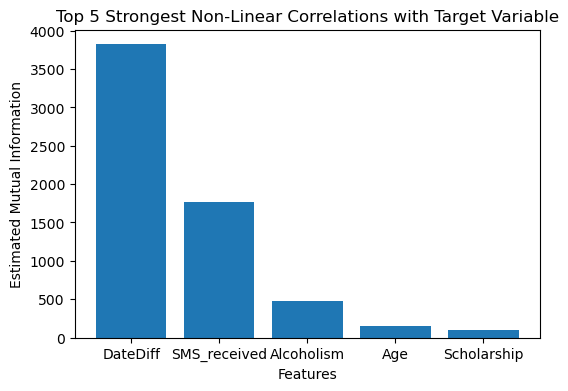

In [28]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X_nums, Y_nums)

cols = X_nums.columns
mi_df = pd.DataFrame(data = mi, index = cols).sort_values(by=0, ascending = False).head(5)

plt.figure(figsize=(6,4))
plt.bar(x=mi_df.index, height = f_df[0])
plt.title('Top 5 Strongest Non-Linear Correlations with Target Variable')
plt.xlabel('Features')
plt.ylabel('Estimated Mutual Information')

Both plots look similar, with DateDiff and SMS_received being our features most correlated with the target variable, ShowedUp. This aligns with our pearson correlation plot.

#### Converting Gender Strings 'M' and 'F' to 0 and 1

In [29]:
df.replace({'Gender':{'M':1, 'F':0}}, inplace = True)

C:\Users\DWang\AppData\Local\Temp\ipykernel_23784\2444683258.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Gender':{'M':1, 'F':0}}, inplace = True)


#### Feature Engineer Day of Week columns + month columns from ScheduledDay and AppointmentDay

In [30]:
df['ApptDayOfWeek'] = pd.to_datetime(df['AppointmentDay']).dt.day_name()
df['ApptMonth'] = pd.to_datetime(df['AppointmentDay']).dt.month_name()

df['SchedDayOfWeek'] = pd.to_datetime(df['ScheduledDay']).dt.day_name()
df['SchedMonth'] = pd.to_datetime(df['ScheduledDay']).dt.month_name()

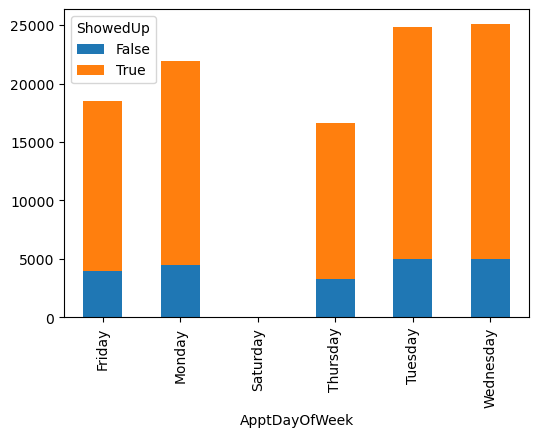

In [31]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['ApptDayOfWeek', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

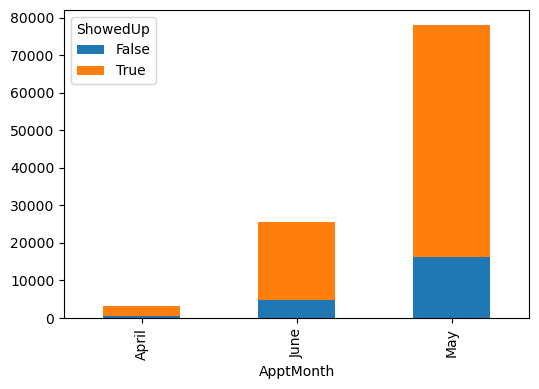

In [32]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['ApptMonth', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

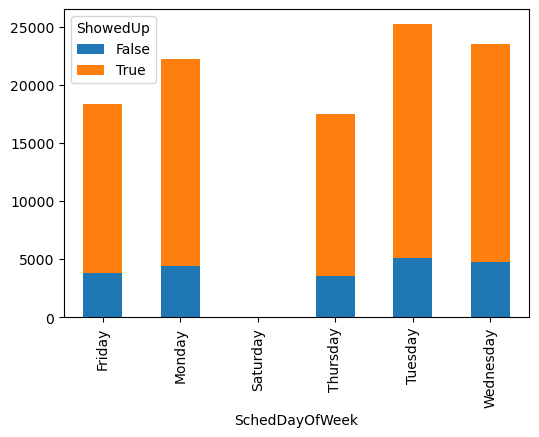

In [33]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['SchedDayOfWeek', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

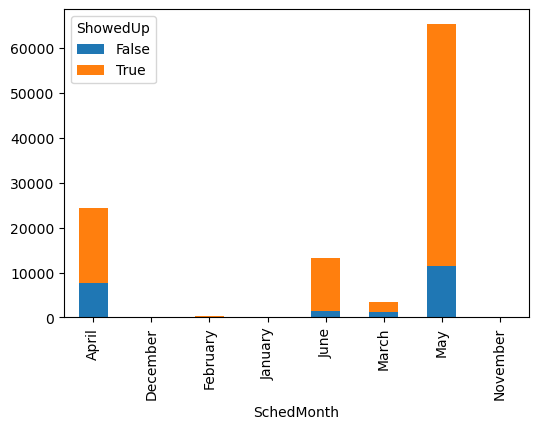

In [34]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['SchedMonth', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

In [35]:
np.unique(df['SchedMonth'])

array(['April', 'December', 'February', 'January', 'June', 'March', 'May',
       'November'], dtype=object)

#### Splitting Data

> Describe briefly how you split the data and why.

Main concern is making sure patients stay within their splits. But also concerned about our imbalanced Target Variable.

Maybe: Split initially with train-test-split with stratify = y to deal with imbalanced data. Then apply GroupShuffleSplit to deal with patients. Problem - what to do with the leftover dataset? And what if we get patients in both sets in our initial split?'

Probable approach: Just use GroupShuffleSplit and adjust our evaluation metrics to deal with the imbalanced dataset.

In [36]:
df[['ScheduledDay', 'AppointmentDay', 'ApptDayOfWeek', 'ApptMonth', 'SchedDayOfWeek', 'SchedMonth']].sample(frac=1)

,ScheduledDay,AppointmentDay,ApptDayOfWeek,ApptMonth,SchedDayOfWeek,SchedMonth
87869,2016-06-08,2016-06-08,Wednesday,June,Wednesday,June
32446,2016-04-25,2016-05-17,Tuesday,May,Monday,April
15494,2016-05-03,2016-05-04,Wednesday,May,Tuesday,May
35794,2016-05-06,2016-05-11,Wednesday,May,Friday,May
41098,2016-05-31,2016-05-31,Tuesday,May,Tuesday,May
...,...,...,...,...,...,...
100793,2016-06-07,2016-06-07,Tuesday,June,Tuesday,June
6141,2016-05-18,2016-05-20,Friday,May,Wednesday,May
32161,2016-05-24,2016-05-24,Tuesday,May,Tuesday,May
300,2016-03-30,2016-04-29,Friday,April,Wednesday,March


In [37]:
# Deprecating this
"""
from sklearn.model_selection import GroupShuffleSplit
random_state = 42
X = df.drop(['PatientID','ShowedUp'], axis=1)
y = df['ShowedUp']
groups = df['PatientID']

# train:val:test = 60:20:20
gss = GroupShuffleSplit(n_splits = 1, test_size = 0.2, random_state=random_state)

#Split training+validation and test
for train_val_index, test_index in gss.split(X, y, groups):
    X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
    y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
    groups_train_val = groups.iloc[train_val_index]

# 0.25 * 0.8 = 0.2
gss = GroupShuffleSplit(n_splits = 1, test_size = 0.25, random_state=random_state)
# Split training+validation into training and validation
for train_index, val_index in gss.split(X_train_val, y_train_val, groups_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    groups_train, groups_val = groups_train_val.iloc[train_index], groups_train_val.iloc[val_index]
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)
"""

'\nfrom sklearn.model_selection import GroupShuffleSplit\nrandom_state = 42\nX = df.drop([\'PatientID\',\'ShowedUp\'], axis=1)\ny = df[\'ShowedUp\']\ngroups = df[\'PatientID\']\n\n# train:val:test = 60:20:20\ngss = GroupShuffleSplit(n_splits = 1, test_size = 0.2, random_state=random_state)\n\n#Split training+validation and test\nfor train_val_index, test_index in gss.split(X, y, groups):\n    X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]\n    y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]\n    groups_train_val = groups.iloc[train_val_index]\n\n# 0.25 * 0.8 = 0.2\ngss = GroupShuffleSplit(n_splits = 1, test_size = 0.25, random_state=random_state)\n# Split training+validation into training and validation\nfor train_index, val_index in gss.split(X_train_val, y_train_val, groups_train_val):\n    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]\n    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]\n 

In [38]:
X.head()

,PatientID,Gender,ScheduledDay,AppointmentDay,DateDiff,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received
0,29872499824296,F,2016-04-29,2016-04-29,0,62,JARDIM DA PENHA,False,True,False,False,False,False
1,558997776694438,M,2016-04-29,2016-04-29,0,56,JARDIM DA PENHA,False,False,False,False,False,False
2,4262962299951,F,2016-04-29,2016-04-29,0,62,MATA DA PRAIA,False,False,False,False,False,False
3,867951213174,F,2016-04-29,2016-04-29,0,8,PONTAL DE CAMBURI,False,False,False,False,False,False
4,8841186448183,F,2016-04-29,2016-04-29,0,56,JARDIM DA PENHA,False,True,True,False,False,False


In [39]:
from sklearn.model_selection import StratifiedGroupKFold
random_state = 1030
X = df.drop(['PatientID','ShowedUp', 'ScheduledDay', 'AppointmentDay'], axis=1)
y = df['ShowedUp']
groups = df['PatientID']

sgkf = StratifiedGroupKFold(n_splits=5, random_state=1030, shuffle=True)

# 1st split - split train+val and test sets
for trainval_index, test_index in sgkf.split(X, y, groups=groups):
    X_trainval, X_test = X.iloc[trainval_index], X.iloc[test_index]
    y_trainval, y_test = y.iloc[trainval_index], y.iloc[test_index]
    groups_trainval = groups.iloc[trainval_index]

sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=1030, shuffle=True)
# 2nd split - splitting trainval into training and validation sets
for train_index, val_index in sgkf_2.split(X_trainval, y_trainval, groups = groups_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

In [40]:
X.shape

(106987, 15)

In [41]:
for key, value in {"X":X, "X_train":X_train, "X_val": X_val, "X_test":X_test}.items():
    print(f'{key} rows: \t{value.shape[0]}')

X rows: 	106987
X_train rows: 	63853
X_val rows: 	21810
X_test rows: 	21324


### Preprocessing the Data

>What preprocessors did you use and why? 
>
>How many features and data points do you have before and after preprocessing. 
>
>If you have missing values, describe the basic properties of the missing values (e.g., what fraction of the points have missing values, which features, what fraction of the features are missing, etc).


To do:
- Convert Gender Strings 'M' and 'F' into 0 and 1
- normalize Age (MinMax Scaler)
- standardize DateDiff (StandardScaler)
- Figure out what to do with our non-numerical features: ScheduledDay, AppointmentDay, and Neighbourhood
- - One Hot Encode Neighbourhood (81 unique values)

Maybe:
- Feature engineer ScheduledDay_IsSunday? ... ScheduledDay_IsSaturday? and AppointmentDay...IsSunday? etc. 
- or ScheduledDate_IsWeekend? ...IsWeekday? if want to be less granular
- or Season?

Thoughts: Given that we have several repeated patients in our dataset, it would stand to reason that the feature values for each of their appointments are identical other than in ScheduledDay, AppointmentDay, and DateDiff. Therefore, feature engineering based on these columns could further differentiate the date?


#### Choosing an Evaluation Metric

Are we going this far for the midterm presentation?

#### Use a Pipeline for the following
- normalize Age (MinMax Scaler)
- standardize DateDiff (StandardScaler)
- one hot encode neighbourhood (81 unique values)
- one-hot encode:
    - ApptDayOfWeek
    - SchedDayOfWeek
    - ApptMonth
    - SchedMonth

^ thought about ordinal encoding but there really isn't a "ranking" to days in a week or months other than the order they come in. One isn't inherently "less" than another.

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn import set_config
"""
ordinal_ftrs = ['ApptDayOfWeek', 'SchedDayOfWeek', 'ApptMonth', 'SchedMonth'] 
# sunday doesn't show up in DayOfWeek columns
ordinal_cats = [['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],\
                ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],\
                ['January', 'February', 'March', 'April', 'May', 'June', 'July' ,'August', 'September', 'October', 'November', 'December'],\
                ['January', 'February', 'March', 'April', 'May', 'June', 'July' ,'August', 'September', 'October', 'November', 'December']]
"""
onehot_ftrs = ['Neighbourhood', 'ApptDayOfWeek', 'SchedDayOfWeek', 'ApptMonth', 'SchedMonth']
minmax_ftrs = ['Age']
std_ftrs = ['DateDiff']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        #('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)]
        , remainder = 'passthrough')
set_config(transform_output="pandas")
clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train.shape)
print(X_train_prep.shape)
#print(X_train_prep)
print(X_val.shape)
print(X_val_prep.shape)
print(X_test.shape)
print(X_test_prep.shape)


(63853, 15)
(63853, 113)
(21810, 15)
(21810, 113)
(21324, 15)
(21324, 113)


Check the results of our Preprocessing

In [43]:
[i for i in X_train_prep.columns]

['onehot__Neighbourhood_AEROPORTO',
 'onehot__Neighbourhood_ANDORINHAS',
 'onehot__Neighbourhood_ANTÔNIO HONÓRIO',
 'onehot__Neighbourhood_ARIOVALDO FAVALESSA',
 'onehot__Neighbourhood_BARRO VERMELHO',
 'onehot__Neighbourhood_BELA VISTA',
 'onehot__Neighbourhood_BENTO FERREIRA',
 'onehot__Neighbourhood_BOA VISTA',
 'onehot__Neighbourhood_BONFIM',
 'onehot__Neighbourhood_CARATOÍRA',
 'onehot__Neighbourhood_CENTRO',
 'onehot__Neighbourhood_COMDUSA',
 'onehot__Neighbourhood_CONQUISTA',
 'onehot__Neighbourhood_CONSOLAÇÃO',
 'onehot__Neighbourhood_CRUZAMENTO',
 'onehot__Neighbourhood_DA PENHA',
 'onehot__Neighbourhood_DE LOURDES',
 'onehot__Neighbourhood_DO CABRAL',
 'onehot__Neighbourhood_DO MOSCOSO',
 'onehot__Neighbourhood_DO QUADRO',
 'onehot__Neighbourhood_ENSEADA DO SUÁ',
 'onehot__Neighbourhood_ESTRELINHA',
 'onehot__Neighbourhood_FONTE GRANDE',
 'onehot__Neighbourhood_FORTE SÃO JOÃO',
 'onehot__Neighbourhood_FRADINHOS',
 'onehot__Neighbourhood_GOIABEIRAS',
 'onehot__Neighbourhood_GR

In [44]:
print(X_train['DateDiff'].describe())
print('\n')
print(X_train_prep['std__DateDiff'].describe())

count    63853.000000
mean        10.157174
std         15.222133
min         -1.000000
25%          0.000000
50%          4.000000
75%         15.000000
max        179.000000
Name: DateDiff, dtype: float64


count    6.385300e+04
mean    -4.451116e-17
std      1.000008e+00
min     -7.329630e-01
25%     -6.672687e-01
50%     -4.044914e-01
75%      3.181462e-01
max      1.109202e+01
Name: std__DateDiff, dtype: float64


In [45]:
df_re = pd.read_csv('data/healthcare_noshows_appointments.csv', dtype={'PatientId': str, 'AppointmentID': str}).drop('Showed_up', axis=1)
display(df_re.head())
display(df_re.shape)
display(X_train_prep.head())
display(X_train_prep.shape)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Date.diff
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,0


(106987, 14)

,onehot__Neighbourhood_AEROPORTO,onehot__Neighbourhood_ANDORINHAS,onehot__Neighbourhood_ANTÔNIO HONÓRIO,onehot__Neighbourhood_ARIOVALDO FAVALESSA,onehot__Neighbourhood_BARRO VERMELHO,onehot__Neighbourhood_BELA VISTA,onehot__Neighbourhood_BENTO FERREIRA,onehot__Neighbourhood_BOA VISTA,onehot__Neighbourhood_BONFIM,onehot__Neighbourhood_CARATOÍRA,...,minmax__Age,std__DateDiff,remainder__Gender,remainder__Scholarship,remainder__Hypertension,remainder__Diabetes,remainder__Alcoholism,remainder__Handicap,remainder__SMS_received,remainder__Diff1Month
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.482456,-0.667269,1,False,False,False,False,False,False,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061404,-0.667269,0,False,False,False,False,False,False,False
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.157895,-0.535880,0,False,False,False,False,False,False,False
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.254386,-0.535880,0,False,False,False,False,False,False,False
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.184211,-0.601574,0,True,False,False,False,False,False,False


(63853, 113)